In [272]:
import arrow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import chinese_calendar as calendar

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.font_manager import FontManager, FontProperties

# 设置全局字体为中文字体
font_path = '/System/Library/Fonts/PingFang.ttc'
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

In [193]:
# 门店数据
store_df = pd.read_csv('./data/线上门店数据.csv')
store_df['created_at'] = pd.to_datetime(store_df['created_at']).dt.date
store_df['store_created_day'] = store_df['created_at'].apply(lambda x: x.strftime('%Y%m%d'))
store_df['store_index'] = store_df.index + 1
store_df = store_df.rename(columns={'store_id': '门店', 'store_index': '门店标识'})
store_cnt = store_df.index.size
store_df

,门店,store_name,store_poi_lon,store_poi_lat,created_at,store_created_day,门店标识
0,64a6bab08c50f36208e3e4bd,小胖子麻辣烫,116.534800,39.905940,2023-07-06,20230706,1
1,64a6bcc8ecd6906ad9127316,小九麻辣烫朝阳分店,116.521310,39.909960,2023-07-06,20230706,2
2,64a6bd6abf398c5ef216f544,小九麻辣烫海淀分店,116.318282,40.033836,2023-07-06,20230706,3
3,64a6bdfaecd6906ad912731e,小胖子麻辣烫朝阳区,116.404000,39.928000,2023-07-06,20230706,4
4,64a6c062bf398c5ef216f54e,小九麻辣烫深圳分店,116.404000,39.928000,2023-07-06,20230706,5
5,64a6c466bf398c5ef216f578,小胖子麻辣烫深圳,114.126860,22.556740,2023-07-06,20230706,6
6,64a6c7c1d88f0169da36e252,测试-便利店新供给（百川店）,116.657380,39.883270,2023-07-06,20230706,7
7,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,114.047668,22.634126,2023-07-17,20230717,8
8,64c5065609e110cd744c160d,传媒大学店,116.549711,39.909747,2023-07-29,20230729,9


In [278]:
def is_holiday(date):
    """
    判断是否是节假日
    """
    return calendar.is_holiday(date)

def is_weekend(date):
    """
    判断是否是周末
    """
    return date.weekday() in [5, 6]


def is_rainy_day(text):
    """
    判断是否是雨天
    """
    return '雨' in text


def is_sunny_day(text):
    """
    判断是否是晴天
    """
    return '晴' in text


def is_snowy_day(text):
    """
    判断是否是雪天
    """
    return '雪' in text


def is_overcast_day(text):
    """
    判断是否是阴天
    """
    return '阴' in text


def is_cloudy_day(text):
    """
    判断是否是多云
    """
    return '多云' in text

In [279]:
dtype = {
    '最低温度': float,
    '最高温度': float,
    '雨量等级': int,
}
weather_df = pd.read_csv('./data/深圳天气数据.csv', dtype=dtype)
weather_df['温度'] = (weather_df['最低温度'] + weather_df['最高温度']) / 2
weather_df['date'] = pd.to_datetime(weather_df['日期'], format='%Y年%m月%d日', errors='ignore')
weather_df['星期'] = weather_df['date'].dt.weekday
weather_df['日期'] = weather_df['date'].dt.date
weather_df['日期'] = weather_df['日期'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
weather_df['是否节假日'] =  weather_df['date'].apply(lambda x: int(is_holiday(x)))
weather_df['是否周末'] =  weather_df['date'].apply(lambda x: int(is_weekend(x)))
weather_df['是否雨天'] = weather_df['天气状况'].apply(lambda x: int(is_rainy_day(x)))
weather_df['是否晴天'] = weather_df['天气状况'].apply(lambda x: int(is_sunny_day(x)))
weather_df['是否雪天'] = weather_df['天气状况'].apply(lambda x: int(is_snowy_day(x)))
weather_df['是否阴天'] = weather_df['天气状况'].apply(lambda x: int(is_overcast_day(x)))
weather_df['是否多云'] = weather_df['天气状况'].apply(lambda x: int(is_cloudy_day(x)))
weather_df

,日期,天气状况,风力风向(夜间/白天),最高温度,最低温度,风力,天气,温度,date,星期,是否节假日,是否周末,是否雨天,是否晴天,是否雪天,是否阴天,是否多云
0,20230701,雷阵雨 /雷阵雨,北风 1-2级 /北风 1-2级,26.0,31.0,1.5,22,28.5,2023-07-01,5,1,1,1,0,0,0,0
1,20230702,阵雨 /多云,北风 1-2级 /北风 1-2级,27.0,31.0,1.5,23,29.0,2023-07-02,6,1,1,1,0,0,0,1
2,20230703,阵雨 /雷阵雨,北风 1-2级 /北风 1-2级,26.0,32.0,1.5,23,29.0,2023-07-03,0,0,0,1,0,0,0,0
3,20230704,雷阵雨 /多云,北风 1-2级 /北风 1-2级,26.0,33.0,1.5,22,29.5,2023-07-04,1,0,0,1,0,0,0,1
4,20230705,多云 /多云,北风 1-2级 /北风 1-2级,27.0,33.0,1.5,12,30.0,2023-07-05,2,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,20230908,暴雨 /大雨,东风 1-3级 /东风 1-3级,24.0,28.0,2.0,26,26.0,2023-09-08,4,0,0,1,0,0,0,0
70,20230909,暴雨 /大雨,北风 1-3级 /北风 1-3级,24.0,27.0,2.0,26,25.5,2023-09-09,5,1,1,1,0,0,0,0
71,20230910,阵雨 /阵雨,东南风 1-3级 /东南风 1-3级,24.0,28.0,2.0,23,26.0,2023-09-10,6,1,1,1,0,0,0,0
72,20230911,阵雨 /阵雨,北风 1-3级 /北风 1-3级,25.0,29.0,2.0,23,27.0,2023-09-11,0,0,0,1,0,0,0,0


In [196]:
dtype = {
    'city_code': 'str'
}
order_df = pd.read_csv('./data/线上-全部城市-20230913-订单.csv', dtype=dtype)
date_field = 'accepted_at'
order_df = order_df[order_df['city_code'] == '440300']
order_df['date'] = pd.to_datetime(order_df[date_field])  # 将日期转换为时间格式
order_df = order_df.rename(columns={'shipping_date': 'book_day'})
order_df['day'] = order_df['date'].dt.day
order_df['hour'] = order_df['date'].dt.hour
order_df['weekday'] = order_df['date'].dt.weekday
order_df

,book_day,city_code,city_name,store_id,store_name,operator_id,operator_name,order_id,seller_order_id,distance,...,created_at,confirmed_at,accepted_at,arrived_at,pickup_at,done_at,date,day,hour,weekday
45,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b79ee51b833a167ab6ae79,田君宁,64c8657267e2ce742b066c2d,64c8657267e2ce742b066c27,3467,...,2023-08-01T09:52:50.881000+08:00,2023-08-01T09:52:50.885000+08:00,2023-08-01T09:52:52.341000+08:00,2023-08-01T09:56:52.528000+08:00,2023-08-01T09:56:57.516000+08:00,2023-08-01T10:31:05.708000+08:00,2023-08-01 09:52:52.341000+08:00,1,9,1
46,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b79ee51b833a167ab6ae79,田君宁,64c8666c67e2ce742b066c53,64c8666c67e2ce742b066c4d,2380,...,2023-08-01T09:57:00.163000+08:00,2023-08-01T09:57:00.168000+08:00,2023-08-01T09:57:01.179000+08:00,2023-08-01T09:57:48.157000+08:00,2023-08-01T09:59:31.654000+08:00,2023-08-01T10:16:45.537000+08:00,2023-08-01 09:57:01.179000+08:00,1,9,1
47,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c71e80ec5d8f84e32b9344,钟彬,64c8673f67e2ce742b066c82,64c8673f67e2ce742b066c7c,17,...,2023-08-01T10:00:31.516000+08:00,2023-08-01T10:00:31.521000+08:00,2023-08-01T10:00:32.861000+08:00,2023-08-01T10:01:03.557000+08:00,2023-08-01T10:02:28.897000+08:00,2023-08-01T10:04:12.317000+08:00,2023-08-01 10:00:32.861000+08:00,1,10,1
48,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c750d82c3f486bbfec6af3,李焜湖,64c868fb67e2ce742b066ca3,64c868fb67e2ce742b066c9d,3691,...,2023-08-01T10:07:55.228000+08:00,2023-08-01T10:07:55.232000+08:00,2023-08-01T10:07:56.616000+08:00,2023-08-01T10:08:09.988000+08:00,2023-08-01T10:10:37.722000+08:00,2023-08-01T10:39:00.270000+08:00,2023-08-01 10:07:56.616000+08:00,1,10,1
49,20230801,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c71d900f319a4d852ad78f,黄有元,64c86b9267e2ce742b066cc2,64c86b9267e2ce742b066cbc,931,...,2023-08-01T10:18:58.212000+08:00,2023-08-01T10:18:58.216000+08:00,2023-08-01T10:18:59.859000+08:00,2023-08-01T10:19:21.921000+08:00,2023-08-01T10:21:10.476000+08:00,2023-08-01T10:33:50.994000+08:00,2023-08-01 10:18:59.859000+08:00,1,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15080,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b8a8c3ba28d89fe44e4f81,方晓邦,65010ee5ca1b6d551e9b7c3c,65010ee5ca1b6d551e9b7c36,788,...,2023-09-13T09:22:45.600000+08:00,2023-09-13T09:22:45.605000+08:00,2023-09-13T09:27:53.293000+08:00,2023-09-13T09:30:57.842000+08:00,2023-09-13T09:37:17.553000+08:00,2023-09-13T09:42:38.661000+08:00,2023-09-13 09:27:53.293000+08:00,13,9,2
15081,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64c71a7c84aae8413855d884,李赟,6501102bca1b6d551e9b7c5b,6501102bca1b6d551e9b7c55,2264,...,2023-09-13T09:28:11.670000+08:00,2023-09-13T09:28:11.675000+08:00,2023-09-13T09:34:51.302000+08:00,2023-09-13T09:45:32.801000+08:00,2023-09-13T09:45:34.142000+08:00,2023-09-13T10:02:17.598000+08:00,2023-09-13 09:34:51.302000+08:00,13,9,2
15082,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64b8a8c3ba28d89fe44e4f81,方晓邦,650111aeca1b6d551e9b7c74,650111aeca1b6d551e9b7c6e,723,...,2023-09-13T09:34:38.817000+08:00,2023-09-13T09:34:38.821000+08:00,2023-09-13T09:34:51.348000+08:00,2023-09-13T09:34:59.621000+08:00,2023-09-13T09:37:18.673000+08:00,2023-09-13T09:47:54.796000+08:00,2023-09-13 09:34:51.348000+08:00,13,9,2
15083,20230913,440300,全部城市,64b5044e406bb091e6fb23c7,松鼠便利超市（龙华店）,64cc67d104d9a5e986f8efdc,赖阳武,6501150fca1b6d551e9b7c98,6501150fca1b6d551e9b7c92,2956,...,2023-09-13T09:49:03.342000+08:00,2023-09-13T09:49:03.346000+08:00,2023-09-13T09:49:04.649000+08:00,2023-09-13T09:53:20.411000+08:00,2023-09-13T10:11:39.768000+08:00,2023-09-13T10:24:28.646000+08:00,2023-09-13 09:49:04.649000+08:00,13,9,2


In [166]:
# 给日期设置对应的颜色，进行区分
days = weather_df['日期']
colors = cm.tab20(np.linspace(0, 0.95, len(days)))
color_map = {day: color for day, color in zip(days, colors)}
color_map

{20230801: array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 20230802: array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 20230803: array([0.68235294, 0.78039216, 0.90980392, 1.        ]),
 20230804: array([0.68235294, 0.78039216, 0.90980392, 1.        ]),
 20230805: array([1.        , 0.49803922, 0.05490196, 1.        ]),
 20230806: array([1.        , 0.73333333, 0.47058824, 1.        ]),
 20230807: array([1.        , 0.73333333, 0.47058824, 1.        ]),
 20230808: array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
 20230809: array([0.59607843, 0.8745098 , 0.54117647, 1.        ]),
 20230810: array([0.59607843, 0.8745098 , 0.54117647, 1.        ]),
 20230811: array([0.83921569, 0.15294118, 0.15686275, 1.        ]),
 20230812: array([0.83921569, 0.15294118, 0.15686275, 1.        ]),
 20230813: array([1.        , 0.59607843, 0.58823529, 1.        ]),
 20230814: array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 20230815: array([0.58039216, 0.40392157, 0.7411

In [197]:
# 按小时统计订单量
hour_order_df = order_df.groupby(['book_day', 'hour']).size().reset_index(name='order_count')
hour_order_df

,book_day,hour,order_count
0,20230801,9,2
1,20230801,10,13
2,20230801,11,20
3,20230801,12,23
4,20230801,13,13
...,...,...,...
1008,20230913,4,2
1009,20230913,6,5
1010,20230913,7,4
1011,20230913,8,4


In [198]:
# 按天和时间展示单量
day_hour_order_df = hour_order_df.set_index(['book_day', 'hour'])['order_count']
day_hour_order_df = day_hour_order_df.unstack('book_day')
day_hour_order_df = day_hour_order_df.fillna(0)
day_hour_order_df

book_day,20230801,20230802,20230803,20230804,20230805,20230806,20230807,20230808,20230809,20230810,...,20230904,20230905,20230906,20230907,20230908,20230909,20230910,20230911,20230912,20230913
hour,,,,,,,,,,,,,,,,,,,,,
0,0.0,24.0,18.0,17.0,15.0,7.0,9.0,19.0,12.0,8.0,...,15.0,21.0,9.0,13.0,6.0,17.0,19.0,13.0,18.0,15.0
1,0.0,7.0,11.0,10.0,15.0,9.0,9.0,9.0,11.0,4.0,...,10.0,5.0,6.0,8.0,1.0,13.0,8.0,10.0,9.0,8.0
2,0.0,7.0,7.0,13.0,6.0,4.0,6.0,4.0,7.0,7.0,...,7.0,5.0,2.0,5.0,0.0,11.0,8.0,1.0,5.0,9.0
3,0.0,4.0,7.0,5.0,6.0,5.0,1.0,1.0,1.0,6.0,...,5.0,3.0,8.0,6.0,5.0,6.0,4.0,0.0,5.0,11.0
4,0.0,4.0,1.0,3.0,3.0,3.0,5.0,0.0,2.0,4.0,...,9.0,1.0,4.0,4.0,0.0,5.0,4.0,6.0,9.0,2.0
5,0.0,7.0,1.0,8.0,3.0,2.0,4.0,2.0,5.0,4.0,...,2.0,2.0,3.0,5.0,3.0,7.0,2.0,7.0,2.0,0.0
6,0.0,5.0,3.0,3.0,5.0,1.0,1.0,2.0,6.0,3.0,...,2.0,3.0,7.0,2.0,1.0,5.0,4.0,2.0,2.0,5.0
7,0.0,11.0,3.0,3.0,7.0,5.0,2.0,1.0,9.0,3.0,...,3.0,1.0,2.0,8.0,6.0,7.0,4.0,4.0,6.0,4.0
8,0.0,6.0,10.0,10.0,10.0,14.0,8.0,10.0,8.0,8.0,...,7.0,8.0,6.0,11.0,14.0,10.0,7.0,7.0,8.0,4.0


In [199]:
# 按天统计单量
day_order_df = order_df.groupby('book_day').size().reset_index(name='order_count')
day_order_df = day_order_df.rename(columns={'book_day': '日期', 'order_count': '单量'})
day_order_df

,日期,单量
0,20230801,305
1,20230802,331
2,20230803,344
3,20230804,435
4,20230805,411
5,20230806,344
6,20230807,301
7,20230808,311
8,20230809,322
9,20230810,307


In [200]:
# 按门店统计单量
store_day_order_df = order_df.groupby(['book_day', 'store_id']).size().reset_index(name='order_count')
store_day_order_df = store_day_order_df.rename(columns={'book_day': '日期', 'store_id': '门店', 'order_count': '单量'})
store_day_order_df

,日期,门店,单量
0,20230801,64b5044e406bb091e6fb23c7,305
1,20230802,64b5044e406bb091e6fb23c7,331
2,20230803,64b5044e406bb091e6fb23c7,344
3,20230804,64b5044e406bb091e6fb23c7,435
4,20230805,64b5044e406bb091e6fb23c7,411
5,20230806,64b5044e406bb091e6fb23c7,344
6,20230807,64b5044e406bb091e6fb23c7,301
7,20230808,64b5044e406bb091e6fb23c7,311
8,20230809,64b5044e406bb091e6fb23c7,322
9,20230810,64b5044e406bb091e6fb23c7,307


In [281]:
store_weather_day_order_df = store_day_order_df.merge(weather_df, on='日期', how='inner')
store_weather_day_order_df = store_weather_day_order_df.merge(store_df[['门店', '门店标识']], on='门店', how='inner')
# store_weather_day_order_df.to_csv('./data/线上门店天气单量数据.csv')
store_weather_day_order_df

,日期,门店,单量,天气状况,风力风向(夜间/白天),最高温度,最低温度,风力,天气,温度,date,星期,是否节假日,是否周末,是否雨天,是否晴天,是否雪天,是否阴天,是否多云,门店标识
0,20230801,64b5044e406bb091e6fb23c7,305,晴 /阵雨,北风 1-2级 /北风 1-2级,27.0,33.0,1.50,23,30.0,2023-08-01,1,0,0,1,1,0,0,0,8
1,20230802,64b5044e406bb091e6fb23c7,331,多云 /多云,北风 1-2级 /北风 1-2级,27.0,33.0,1.50,12,30.0,2023-08-02,2,0,0,0,0,0,0,1,8
2,20230803,64b5044e406bb091e6fb23c7,344,雷阵雨 /雷阵雨,北风 1-2级 /北风 1-2级,26.0,33.0,1.50,22,29.5,2023-08-03,3,0,0,1,0,0,0,0,8
3,20230804,64b5044e406bb091e6fb23c7,435,阵雨 /阵雨,西南风 3-4级 /西南风 3-4级,26.0,32.0,3.50,23,29.0,2023-08-04,4,0,0,1,0,0,0,0,8
4,20230805,64b5044e406bb091e6fb23c7,411,雷阵雨 /多云,西南风 3-4级 /北风 1-2级,27.0,32.0,2.50,22,29.5,2023-08-05,5,1,1,1,0,0,0,1,8
5,20230806,64b5044e406bb091e6fb23c7,344,多云 /多云,北风 1-2级 /北风 1-2级,28.0,33.0,1.50,12,30.5,2023-08-06,6,1,1,0,0,0,0,1,8
6,20230807,64b5044e406bb091e6fb23c7,301,阵雨 /多云,北风 1-2级 /北风 1-2级,26.0,33.0,1.50,23,29.5,2023-08-07,0,0,0,1,0,0,0,1,8
7,20230808,64b5044e406bb091e6fb23c7,311,多云 /多云,北风 1-2级 /北风 1-2级,28.0,33.0,1.50,12,30.5,2023-08-08,1,0,0,0,0,0,0,1,8
8,20230809,64b5044e406bb091e6fb23c7,322,雷阵雨 /中雨,北风 1-2级 /北风 1-2级,27.0,33.0,1.50,24,30.0,2023-08-09,2,0,0,1,0,0,0,0,8
9,20230810,64b5044e406bb091e6fb23c7,307,中雨 /暴雨,北风 1-2级 /北风 1-2级,25.0,33.0,1.50,26,29.0,2023-08-10,3,0,0,1,0,0,0,0,8


In [268]:
store_weather_day_order_df[['天气', '温度']]
store_weather_day_order_df['单量']

0     305
1     331
2     344
3     435
4     411
5     344
6     301
7     311
8     322
9     307
10    317
11    404
12    375
13    297
14    329
15    397
16    333
17    336
18    414
19    361
20    352
21    388
22    431
23    365
24    414
25    412
26    369
27    324
28    394
29    346
30    410
31    401
32    262
33    289
34    302
35    259
36    312
37    287
38    368
39    360
40    369
41    277
42     68
Name: 单量, dtype: int64

门店        64b5044e406bb091e6fb23c7
日期                                
20230801                       305
20230802                       331
20230803                       344
20230804                       435
20230805                       411
20230806                       344
20230807                       301
20230808                       311
20230809                       322
20230810                       307
20230811                       317
20230812                       404
20230813                       375
20230814                       297
20230815                       329
20230816                       397
20230817                       333
20230818                       336
20230819                       414
20230820                       361
20230821                       352
20230822                       388
20230823                       431
20230824                       365
20230825                       414
20230826                       412
20230827            

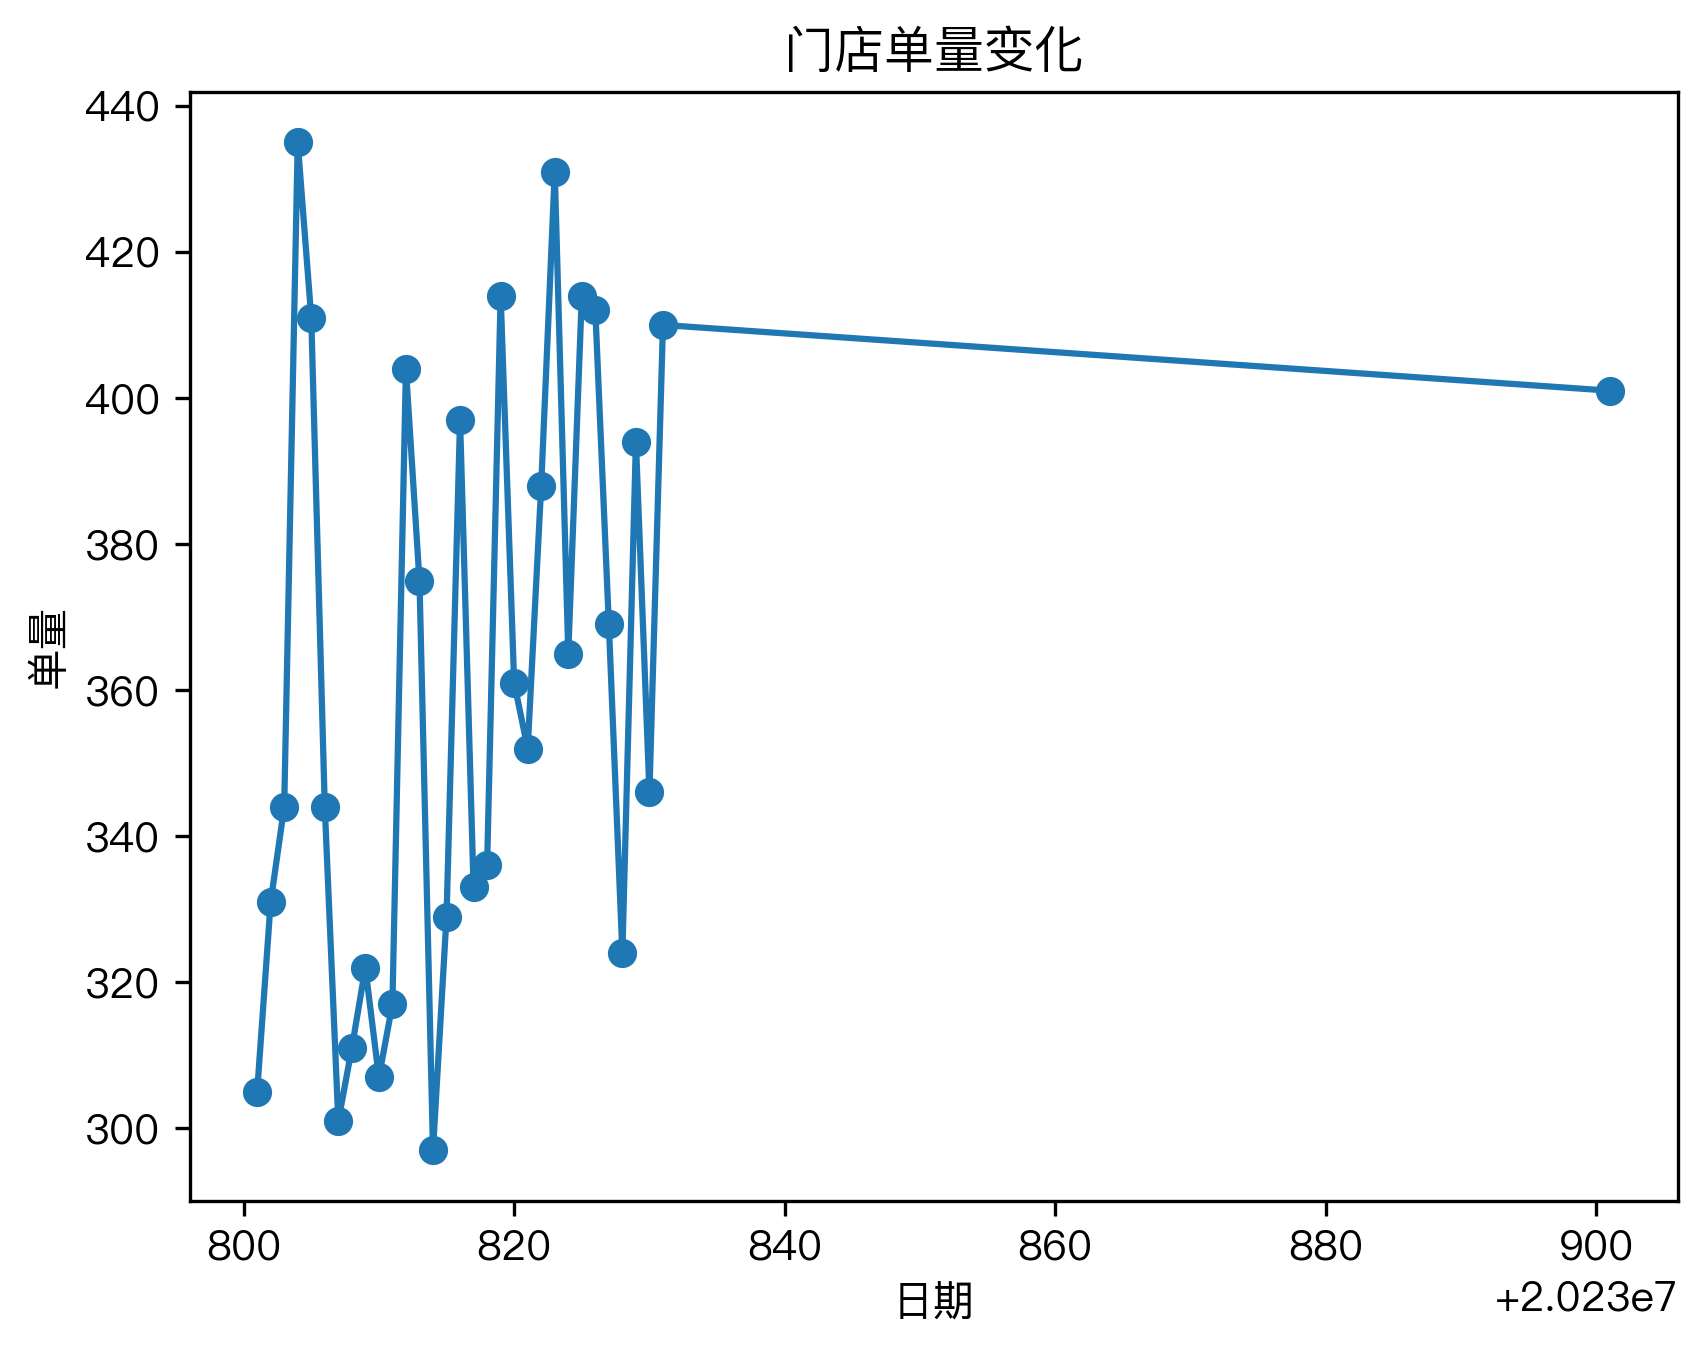

In [265]:
# 绘制温度对单量
fig, ax = plt.subplots(dpi=300)
store_order_df = store_weather_day_order_df[store_weather_day_order_df['日期'] <= 20230901]
store_order_data = store_order_df.set_index(['门店', '日期'])['单量']
store_order_data = store_order_data.unstack('门店')
print(store_order_data)
store_order_data['64b5044e406bb091e6fb23c7'].sort_index().plot(
    ax=fig.gca(), 
    ylabel='单量', 
    xlabel='日期', 
    linestyle='-', 
    marker='o',
)
plt.title('门店单量变化')
plt.show()

In [231]:
# 按日期合并天气数据
df = day_order_df.merge(weather_df, on='日期', how='inner')
df

,日期,单量,天气状况,风力风向(夜间/白天),最高温度,最低温度,风力,天气,温度,date,星期
0,20230801,305,晴 /阵雨,北风 1-2级 /北风 1-2级,27.0,33.0,1.50,23,30.0,2023-08-01,1
1,20230802,331,多云 /多云,北风 1-2级 /北风 1-2级,27.0,33.0,1.50,12,30.0,2023-08-02,2
2,20230803,344,雷阵雨 /雷阵雨,北风 1-2级 /北风 1-2级,26.0,33.0,1.50,22,29.5,2023-08-03,3
3,20230804,435,阵雨 /阵雨,西南风 3-4级 /西南风 3-4级,26.0,32.0,3.50,23,29.0,2023-08-04,4
4,20230805,411,雷阵雨 /多云,西南风 3-4级 /北风 1-2级,27.0,32.0,2.50,22,29.5,2023-08-05,5
5,20230806,344,多云 /多云,北风 1-2级 /北风 1-2级,28.0,33.0,1.50,12,30.5,2023-08-06,6
6,20230807,301,阵雨 /多云,北风 1-2级 /北风 1-2级,26.0,33.0,1.50,23,29.5,2023-08-07,0
7,20230808,311,多云 /多云,北风 1-2级 /北风 1-2级,28.0,33.0,1.50,12,30.5,2023-08-08,1
8,20230809,322,雷阵雨 /中雨,北风 1-2级 /北风 1-2级,27.0,33.0,1.50,24,30.0,2023-08-09,2
9,20230810,307,中雨 /暴雨,北风 1-2级 /北风 1-2级,25.0,33.0,1.50,26,29.0,2023-08-10,3


In [248]:
# 待预测数据
features = ['温度', '天气', '风力', '星期', '门店标识']  # 特征值
target = '单量'  # 目标变量
predict_day = 20230913
temperature = 29
rain_level = 12
wind_speed = 2
week_day = 3
predict_data = {
    '温度': [temperature], 
    '天气': [rain_level], 
    '风力': [wind_speed],
    '星期': [week_day],
    '门店标识': [8],
}

In [249]:
def decision_tree_predict(df):
    """
    使用决策树分析历史天气对单量的影响
    要素：温度、降雨量、风速
    """
    # 划分训练集和测试集
    x_train, x_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2,
                                                        random_state=42)

    # 创建决策树回归模型
    model = DecisionTreeRegressor()
    # 拟合模型
    model.fit(x_train, y_train)
    # 在测试集上进行预测
    y_pred = model.predict(x_test)

    # 评估模型性能
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("均方误差 (MSE):", mse)
    print("回归评分函数 (R2):", r2)

    # 特征重要性分析
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
    print('特征重要性分析：')
    print(feature_importance)

    # 使用模型进行未来订单量预测
    predict_df = pd.DataFrame(predict_data)
    predict_result = model.predict(predict_df)
    predict_df['预测单量'] = predict_result
    print("预测结果: ")
    return predict_df

# print('=' * 50, '总体预测', '=' * 50)
# decision_tree_predict(df, features, target, predict_data)

print('=' * 50, '按门店预测', '=' * 50)
decision_tree_predict(store_weather_day_order_df)

================================================== 按门店预测 ==================================================
均方误差 (MSE): 5164.777777777777
回归评分函数 (R2): -1.2496854128351562
特征重要性分析：
  Feature  Importance
0      温度    0.574807
1      天气    0.178061
2      风力    0.050553
3      星期    0.196580
4    门店标识    0.000000
预测结果: 


,温度,天气,风力,星期,门店标识,预测单量
0,29,12,2,3,8,68.0


In [245]:
def random_forest_predict(df):
    """
    使用随机森林模型进行预测
    """
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

    # 创建随机森林回归模型
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # 设置100个决策树

    # 在训练集上训练模型
    rf_model.fit(X_train, y_train)

    # 在测试集上进行预测
    y_predict = rf_model.predict(X_test)
    print(y_predict)
    
    # 评估模型
    mse = mean_squared_error(y_test, y_predict)
    print(f"均方误差（MSE）: {mse}")

    # 特征重要性分析
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
    print(f'特征重要性分析: {feature_importance}')

    # 特征重要性可视化
    # plt.figure(figsize=(10, 6))
    # sns.barplot(x="Importance", y="Feature", data=feature_importance.sort_values(by="Importance", ascending=False))

    # 使用模型进行未来订单量预测
    predict_df = pd.DataFrame(predict_data)
    predict_result = rf_model.predict(predict_df)
    print("明日单量预测:", predict_result)

random_forest_predict(store_weather_day_order_df)

[340.41 262.17 334.13 198.79 335.38 313.96 398.74 394.85 348.59]
均方误差（MSE）: 5474.498022222221
特征重要性分析:   Feature  Importance
0      温度    0.362008
1      天气    0.240695
2      风力    0.155255
3      星期    0.242042
4    门店标识    0.000000
明日单量预测: [353.5]


In [234]:
# LSTM模型预测
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [246]:
scaled_df = store_weather_day_order_df[['单量', '日期', '温度', '天气', '风力', '星期', '门店标识']]
scaled_df['日期'] = pd.to_datetime(scaled_df['日期'])
scaled_df.set_index('日期', inplace=True)
scaled_df.sort_index(inplace=True)

# 数据预处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(scaled_df)

# 定义训练集和测试集数量
train_data_len = int(len(scaled_data) * 0.8)

# 划分训练集和测试集
train_data = scaled_data[:train_data_len, :]
test_data = scaled_data[train_data_len:, :]

# 创建训练集和测试集的特征和目标变量
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:i+time_steps, :])
        y.append(dataset[i+time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 10  # 设定时间步长，用于定义输入序列的长度
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# 创建并训练LSTM模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', run_eagerly=True)
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

# 预测未来订单数据
predictions = model.predict(X_test)
print(predictions)
predictions = scaler.inverse_transform(predictions)  # 反归一化
# 将预测结果与实际数据进行比较
forecast = pd.DataFrame(predictions, index=scaled_df.index[train_data_len+time_steps:], columns=['预测单量'])
forecast

/var/folders/jg/g_sml8hs01z_489v147wbhkr0000gn/T/ipykernel_44458/3344463598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df['日期'] = pd.to_datetime(scaled_df['日期'])


Epoch 1/10
2/2 [==============================] - 0s 107ms/step - loss: 0.5529
Epoch 2/10
2/2 [==============================] - 0s 112ms/step - loss: 0.3150
Epoch 3/10
2/2 [==============================] - 0s 109ms/step - loss: 0.1318
Epoch 4/10
2/2 [==============================] - 0s 107ms/step - loss: 0.0310
Epoch 5/10
2/2 [==============================] - 0s 109ms/step - loss: 0.0346
Epoch 6/10
2/2 [==============================] - 0s 116ms/step - loss: 0.0828
Epoch 7/10
2/2 [==============================] - 0s 104ms/step - loss: 0.0702
Epoch 8/10
2/2 [==============================] - 0s 106ms/step - loss: 0.0355
Epoch 9/10
2/2 [==============================] - 0s 109ms/step - loss: 0.0170
Epoch 10/10
2/2 [==============================] - 0s 110ms/step - loss: 0.0176


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.